## Referencias

* https://www.ufrgs.br/wiki-r/index.php?title=Data_Frame (data frame)
* https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/quantile (quantil)


In [1651]:
#install.packages("dplyr")
#install.packages("ggplot2") 
library("dplyr")
library("ggplot2")  

In [1631]:
# Adicionando o diretorio atual
setwd("../");

In [1652]:
# Le o dataset com as colunas desejadas
dataset <- read.csv(file="./summer-products-with-rating-and-performance_2020-08.csv", header=TRUE, sep=",")
dataset <- as.data.frame(dataset)
base    <- select(dataset, price, units_sold, rating, rating_count, retail_price,  merchant_rating, merchant_rating_count)

# Nomes alternativos
colnames(base) <- c("Price", "Units Sold", "Rating", "Rating C", "Retail Price", "Merch R", "Merch C")

Warning message in file(file, "rt"):
“cannot open file './summer-products-with-rating-and-performance_2020-08.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [1635]:
## Seçao de outliers
# Quartis
Q1 = 0.25
Q2 = 0.5
Q3 = 0.75
Q4 = 1.0

# Calcula Inter Quartile Range (IQR) da lista
iqrange <- function(arr)
{
    quantile(arr, Q3) - quantile(arr, Q1)
}

# Limpa outliers se baseando em uma coluna
limpaOutlier <- function(df, col)
{
    IQR = iqrange(unlist(df[[col]]))
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    subset(df, df[[col]] > lower & df[[col]] < upper)
}

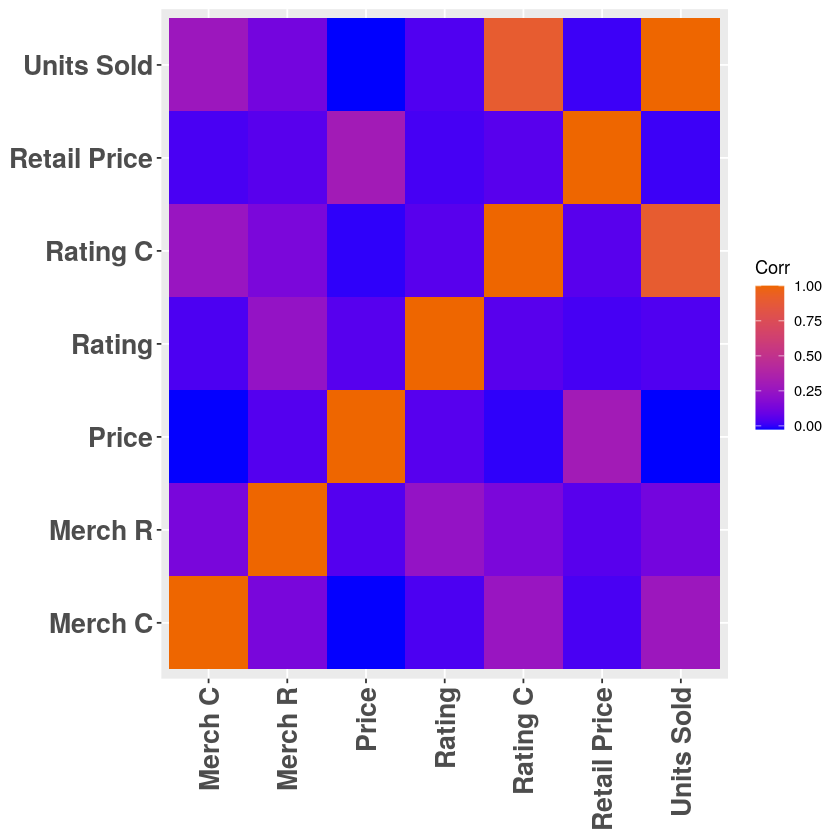

In [1639]:
# Mapa de calor de correlacao
cor_map = data.frame(rows = rep(colnames(base), each = ncol(base)), cols = rep(colnames(base), each = 1, times=ncol(base)), Corr = c(cor(base)), stringsAsFactors=FALSE)

cor_heat = ggplot(cor_map, aes(rows, cols)) + geom_tile(aes(fill = Corr)) 
cor_heat = cor_heat + scale_fill_gradient(low = "#0000FF", high = "#EE6600") + theme(axis.title.y=element_blank(), axis.title.x=element_blank(), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size=16, face="bold"), axis.text.y = element_text(vjust = 0.5, hjust=1, size=16, face="bold"))
cor_heat

# Eliminares os valores com correlacao quase perfeita e muita baixa
cor_map = subset(cor_map, (Corr < 0.99 & Corr > 0.2) | (Corr > -0.99 & Corr < -0.2))

In [1649]:
# Calcula novo cor_map aplicando remocao de outliers 2 a 2

cor_map$Corr_New <- NA
rows = cor_map$"rows"
cols = cor_map$"cols"

for(i in 1:(nrow(cor_map)))
{
    sub_base = limpaOutlier(base, rows[[i]])
    sub_base = limpaOutlier(sub_base, cols[[i]])
    sub_base = select(sub_base, rows[i], cols[[i]])
    cor_map[i, "Corr_New"] = cor(sub_base)[2]
}
cor_map
subset(cor_map, cor_map$Corr_New > cor_map$Corr)

,rows,cols,Corr,Corr_New
,<chr>,<chr>,<dbl>,<dbl>
5,Price,Retail Price,0.3047476,0.3992272
11,Units Sold,Rating C,0.8994637,0.6598791
14,Units Sold,Merch C,0.2728973,0.2758841
20,Rating,Merch R,0.2373051,NA
23,Rating C,Units Sold,0.8994637,0.6848825
28,Rating C,Merch C,0.2581676,0.2826965
29,Retail Price,Price,0.3047476,0.2520592
38,Merch R,Rating,0.2373051,NA
44,Merch C,Units Sold,0.2728973,0.2154947


,rows,cols,Corr,Corr_New
,<chr>,<chr>,<dbl>,<dbl>
5,Price,Retail Price,0.3047476,0.3992272
14,Units Sold,Merch C,0.2728973,0.2758841
28,Rating C,Merch C,0.2581676,0.2826965


In [1519]:
# Regressao Linear

